In [ ]:
pip install massspecgym

In [10]:
import numpy as np
import pandas as pd
embeddings = np.load("/kaggle/input/ms2ds-embeddings/ms2ds_embeddings.npy")
df = pd.read_csv("/kaggle/input/smiles/smiles.csv")
smiles = df["smiles"].tolist()
print(embeddings.shape)
print(len(smiles))

(76, 500)
76


In [12]:
# Compute Molecular Similaraity/Compute Embedding Similarity
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.metrics.pairwise import cosine_similarity


mols = [Chem.MolFromSmiles(s) for s in smiles]
fps = [
    AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
    for m in mols
]
N = len(fps)
tanimoto = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        tanimoto[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

emb_sim = cosine_similarity(embeddings)

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

def upper_triangle(mat):
    idx = np.triu_indices_from(mat, k=1)
    return mat[idx]

y_true = upper_triangle(tanimoto)
y_pred = upper_triangle(emb_sim)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

RMSE: 0.2517737336737044


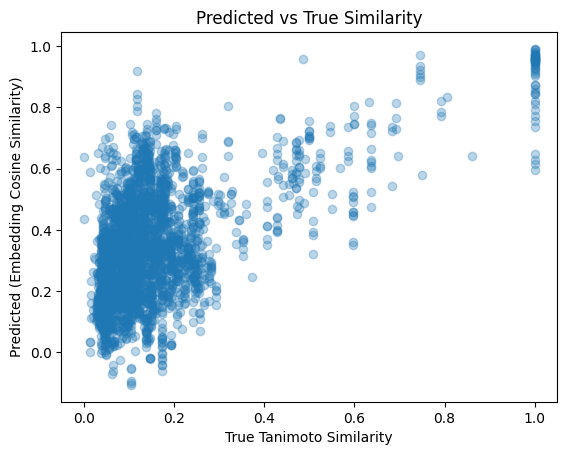

In [17]:
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("True Tanimoto Similarity")
plt.ylabel("Predicted (Embedding Cosine Similarity)")
plt.title("Predicted vs True Similarity")
plt.show()